In [9]:
from scipy import stats as stats_scipy
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import ndimage
from scipy.optimize import curve_fit
import pandas as pd
import csv
from scipy.stats import norm
from sklearn.neighbors.kde import KernelDensity
import nestle


# Q1

  0%|          | 0/7000 [00:00<?, ?it/s]/home/surya/.local/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 7000/7000 [00:12<00:00, 542.22it/s]


Best fit val for f0 is 0.05785160915908258
Best fit val for f1 is 0.08498688851847147


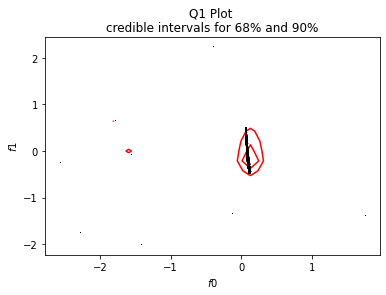

In [63]:
### importing data ...
data = np.loadtxt('Q1.dat')
z,fgas,fsigma = data[:,0],data[:,1],data[:,2]

## helper subroutines...
def model(z, f0, f1):
    return f0 * (1 + f1*z)

def log_prior(a, b):
    if 0 < a < 0.5 and -0.5 < b < 0.5:
        return 0.0
    else:
        return -np.inf

def log_posterior(theta,x,y,yerr):    
    return log_prior(*theta) + log_likelihood(*theta, y, yerr)

def log_likelihood(f0, f1, y, err_y):
    model_out = model(z, f0, f1)
    sig = pow(err_y, 2) + pow(model_out, 2)
    return -0.5 * np.sum((y - model_out) ** 2 / sig + np.log(sig))



#defining params
# respectively no. of params, burn in . MCMC steps, MCMC walkers

ndim, nburn, nsteps, nwalkers = 2,1000,7000,50

#initial guesses
(popt, pcov), initial_guess  = curve_fit(model, z, fgas,sigma = fsigma), np.random.normal(popt, 1, (nwalkers, ndim))


#MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[z,fgas,fsigma])
sampler.run_mcmc(initial_guess, nsteps, progress = True)
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T

best_fit = np.mean(emcee_trace[:,:2],0)
print('Best fit val for f0 is {}'.format(best_fit[0]))
print('Best fit val for f1 is {}'.format(best_fit[1]))


##3 finding xbins, ybins, sig
L, xbins, ybins = np.histogram2d(*emcee_trace, 20)
L[L == 0] = 1e-16
logL = np.log(L)
shape = L.shape
L = L.ravel()
i_sort = np.argsort(L)[::-1]
i_unsort = np.argsort(i_sort)
L_cumsum = L[i_sort].cumsum()
L_cumsum /= L_cumsum[-1]
xbins = 0.5 * (xbins[1:] + xbins[:-1])
ybins = 0.5 * (ybins[1:] + ybins[:-1])
sigma = L_cumsum[i_unsort].reshape(shape)

### Plotting
plt.contour(xbins, ybins, sigma.T, levels=[0.68, 0.90], colors='r')
plt.plot(*emcee_trace, ',k', alpha=0.2)
plt.title('Q1 Plot \n' + 'credible intervals for 68% and 90%')
plt.xlabel(r'$f0$')
plt.ylabel(r'$f1$')
plt.show()


# Q2

In [46]:
## importing data
with open('Q2.npy', 'rb') as f:
    Data =  np.load(f)
    
def poly_fit(theta, x):                                         
    return sum(t * x ** n for (n, t) in enumerate(theta))

def log_prior(theta):
    return 200 * theta - 100
 
def log_likelihood(theta, data=Data):                         #log likelihood function
    x, y, sigma_y = data
    yM = poly_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - yM) ** 2 / sigma_y ** 2)


np.random.seed(0)
linear = nestle.sample(log_likelihood, log_prior, 2)
quadratic = nestle.sample(log_likelihood, log_prior, 3)

In [55]:
print('Summary for Linear Model')
print('--------------------------------')
print(linear.summary())

print('\nSummary for Quadratic Model')
print('--------------------------------')
print(quadratic.summary())


print('\n')

print('Log Evidence for Linear Model  is  -{}'.format(linear.logz))
print('Log Evidence for Quadratic Model  is  -{}'.format(quadratic.logz))

print('\n Observation : The value does not match with those mentioned in JakeVDP blog')

Summary for Linear Model
--------------------------------
niter: 1572
ncall: 2658
nsamples: 1672
logz:  7.148 +/-  0.372
h: 13.820

Summary for Quadratic Model
--------------------------------
niter: 1975
ncall: 5796
nsamples: 2075
logz:  3.970 +/-  0.419
h: 17.543


Log Evidence for Linear Model  is  -7.147593372027539
Log Evidence for Quadratic Model  is  -3.9697900323142328

 Observation : The value does not match with those mentioned in JakeVDP blog


# Q3

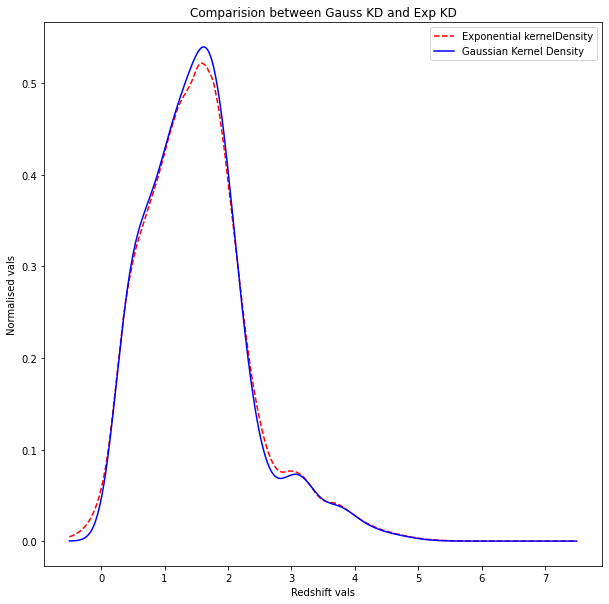

In [44]:
##3 KDE estimate of the quasarredshift dist

Data_pd = pd.read_csv('Q3.txt',sep = '\s+')
Data = Data_pd['z'].to_numpy()

t = np.linspace(-0.5,7.5, 500)

## Kde pdfs

## samples for a gauss dist
gauss_kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Data[:,np.newaxis])
gauss_dist = np.exp(gauss_kde.score_samples(t[:,np.newaxis]) )

## samples for a exp dist
exp_kde = KernelDensity(kernel='exponential', bandwidth=0.2).fit(Data[:,np.newaxis])
exp_dist = np.exp(exp_kde.score_samples(t[:,np.newaxis]) )


plt.figure(figsize = (10, 10))
plt.plot(t, exp_dist,'--r',label = 'Exponential kernelDensity')
plt.plot(t, gauss_dist, 'b', label = 'Gaussian Kernel Density')
plt.title('Comparision between Gauss KD and Exp KD')
plt.xlabel('Redshift vals')
plt.ylabel('Normalised vals')
plt.legend()
plt.show()

#  THE END